In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gradio as gr

from glob import glob
from sklearn.preprocessing import StandardScaler



In [2]:

sequence = "CAACTATTTCAAATTACTTAAATCAATACAACAAATCTCACAACTTGTAAAATTCCAAAAGAAGGAGACGAGGAGAGGAAGCGTACCAGGCTGGTATTATTGGTGGATTGCTTCTCCTTGACAACTTCCTGGACAGAGACGACGGGAGATCGACGGGTGGCGTTGGAGTGATTGAGTCTGCGAAGGGAGAGGGAACGGGTGGATCCGAGGAAAGAAGAAGGAGGAGCCAATCGGATCGGGAGCAAGAGACGATTCTCATGGGATCCATGCAGAGGAACCGTGGCAGTGAGCTTAGTGGGAGCGAAAGCCGTCGCCATTGCTATCAATGGAAACCCCAATGAGATTAACGGAATTCGGAAAAAAAAAAAAAAAACTTTCTGGGAAAATAAAAGAGAGCAGAGATGGGCGGAGAGAACAAGAGATGAGAGGCAGAGGAGGCAGACGATCCCGGCTCTAAATACTTATATATATTTTTATTTGTTTGTTCGAAAAATATTTAATCAATTTTGGACCCACCCTTCTTCGTTAACACCAATGTTTTTTTCTTTCTTTTCATTTCATCTCTTAATTTCAAGATCCGATCTACAAATATAATCCTTGTTAAGTATGCTCAACATAATTTATTTTCTTCTTTAACTCGAATTGGTTAATCAATAGTGGAATCATCAAATTAACAAAATGATCTGAACAAATTCAGGTGAATAACCATAAAATTCTAACCATTTAGAAATATGGCTTTTCAATTGAGTTTTAAGAATAGATCCGTTTTCTTTAAGATTTGTATATAATCCCATAAATCTTTTGTTATCAGGTAGAGCTATAGATGCAACTACTTTTGACTCTAAAAGAAAGAAAATTGAATTTAAAACCTAATTCCTACCGTTACTACTAAATTATTATGAAACATATTTAATCCTCTAAACAACATTTTTTGGTTTTCCTATTTCTCTTACGAAAAATCCCATTACTTTTTTATCGTATTTATCCTTATCTCAATTTCATCAAATGGAATGTATGACAATAGACGTACAAATGTTATGAAGACGCTGCTGGGTAAGAAGAAGAACAAACACTAACATGTTCCGATAATAAAGGCATTGGGCCGGCCTAACATTACTGCAAAAGCCAATTTTATTAAAGACCTATATTTGATGACAATTCTAAATATTGTATGACCGGATTTAACATTTATGGTTTGACGTTTTCGAAATTAAAGACCTATATTTGA "



In [3]:

def one_hot_encode_sequence(seq):
  encoded_seq = []
  for base in seq:
    assert(base in "ACGTN")
    if base == "A":
      encoded_seq.append([1,0,0,0])
    elif base == "C":
      encoded_seq.append([0,1,0,0])
    elif base == "G":
      encoded_seq.append([0,0,1,0])
    elif base == "T":
      encoded_seq.append([0,0,0,1])
    elif base == "N":
      encoded_seq.append([0,0,0,0])
  return np.array(encoded_seq)


In [4]:
def sequence_to_shape(sequence, shape_df):
  shape_of_seq = []
  for index in range(0, len(sequence)):
    current_pentamer = sequence[index-2:index+3]
    if (len(current_pentamer) == 5) and all(base in "ACGT" for base in current_pentamer):
      shape_of_seq.append(shape_df.loc[current_pentamer].to_list())
  return(shape_of_seq)

In [5]:
def get_predictions(model_path, input_features):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # predict
    preds = []
    for sequence_window in input_features:
        input_data = tf.expand_dims(sequence_window, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        preds.append(output_data[0][0])
    
    return preds

In [6]:
def get_sequence_windows(sequence):
    indizes = []
    sequences = []

    for i in range(0,len(sequence),200):
        mer_200 = sequence[i:i+201]
        if len(mer_200) == 201 and all([base in "ACGT" for base in mer_200]):
            indizes.append(i)
            sequences.append(mer_200)


    chromosome_df = pd.DataFrame(sequences,index=indizes,columns=["sequence"])

    return chromosome_df

In [7]:
def calculate_binding_prediction(sequence):
    assert len(sequence) >= 201, "Sequence needs to be longer than 200 base pairs"

    sequence = sequence.strip().upper()
    assert all([base in "ACGT" for base in sequence]), "Sequence can only contain A,C,G or T"

    # paths to models trained on onehot encodings
    model_paths = glob("models_onehot/model_*_onehot.tflite")
    
    # get sequence windows of 200 base pairs with 150 base pair steps
    chromosome_df = get_sequence_windows(sequence)

    # onehot encode
    onehot_encodings = np.stack([one_hot_encode_sequence(seq) for seq in chromosome_df["sequence"]])
    onehot_encodings = tf.convert_to_tensor(onehot_encodings, np.float32)

    # shape encode
    # load query table
    shape_df = pd.read_csv("data/dna_shape_query_final.csv", index_col = 0)
    # normalize shape values
    scaler = StandardScaler()
    shape_df[shape_df.columns] = scaler.fit_transform(shape_df)
    # encode
    shape_encodings = np.stack([sequence_to_shape(seq, shape_df) for seq in chromosome_df["sequence"]])
    shape_encodings = tf.convert_to_tensor(shape_encodings, np.float32)

    
    # predict binding and save predictions > 0.5 in final dataframe
    final_df = pd.DataFrame()

    for model_path in model_paths:
        # initiate model paths
        model_path_onehot = model_path
        model_path_shape = model_path.replace("onehot","shape")
        # generate predictions
        temp_df = chromosome_df.copy()
        temp_df["prediction_onehot"] = get_predictions(model_path, onehot_encodings)
        temp_df["prediction_shape"] = get_predictions(model_path_shape, shape_encodings)
        temp_df["prediction"] = (temp_df["prediction_onehot"] + temp_df["prediction_shape"]) / 2
        temp_df["TF_family"] = model_path.split("_")[2]
        temp_df["TF"] = model_path.split("_")[3]
        final_df = final_df.append(temp_df.query("prediction > 0.75"))

    final_df["position"] = final_df.index + 100

    # keep only the best entry for each family
    final_df = final_df.sort_values(by="prediction", ascending=False) # .drop_duplicates(subset=["TF_family","position"])

    final_df = final_df.reset_index(drop=True)

    return final_df

In [8]:
df = calculate_binding_prediction(sequence)

In [9]:
df

,sequence,prediction_onehot,prediction_shape,prediction,TF_family,TF,position
0,ATCAAATGGAATGTATGACAATAGACGTACAAATGTTATGAAGACG...,0.997730,0.988899,0.993315,AP2EREBP,RAP211,1100
1,ATCAAATGGAATGTATGACAATAGACGTACAAATGTTATGAAGACG...,0.958965,0.974509,0.966737,MYB,MYB116,1100
2,ATCAAATGGAATGTATGACAATAGACGTACAAATGTTATGAAGACG...,0.964733,0.934789,0.949761,MYB,MYB62,1100
3,TTTGTTATCAGGTAGAGCTATAGATGCAACTACTTTTGACTCTAAA...,0.967474,0.913028,0.940251,MYB,MYB118,900
4,CAACTATTTCAAATTACTTAAATCAATACAACAAATCTCACAACTT...,0.884769,0.922213,0.903491,NAC,ANAC017,100
5,ATCAAATGGAATGTATGACAATAGACGTACAAATGTTATGAAGACG...,0.842316,0.957510,0.899913,LOBAS2,LBD2,1100
6,TTTGTTATCAGGTAGAGCTATAGATGCAACTACTTTTGACTCTAAA...,0.900714,0.891485,0.896100,MYB,MYB119,900
7,TTAAGTATGCTCAACATAATTTATTTTCTTCTTTAACTCGAATTGG...,0.923643,0.854265,0.888954,ZFHD,ATHB34,700
8,TTTGTTATCAGGTAGAGCTATAGATGCAACTACTTTTGACTCTAAA...,0.906033,0.848556,0.877295,MYB,MS188,900
9,CAACTATTTCAAATTACTTAAATCAATACAACAAATCTCACAACTT...,0.889636,0.858051,0.873844,bZIP,bZIP52,100


In [27]:
def plot_protein_binding(dataframe):

    fig = plt.figure(figsize=(18,6), facecolor='white')

    sns.scatterplot(x="position", y="prediction", data=dataframe, hue="TF_family", marker="_", s=2000, palette="colorblind")

    plt.xlim(0,dataframe.position.max() + 100)

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    plt.savefig("plot_protein_binding.png", dpi=600, format="png", bbox_inches="tight")

    return plt.gcf() # get current figure


In [28]:
def plot_distribution(dataframe):

    fig = plt.figure(figsize=(18,6), facecolor='white')

    #sns.displot(dataframe, x="position", kind="kde", bw_adjust=.5, height=5, aspect=3)
    sns.histplot(dataframe, x="position", binwidth=200, binrange=(0,dataframe.position.max() + 100))

    plt.xlim(0,dataframe.position.max() + 100)

    plt.savefig("plot_distribution.png", dpi=600, format="png", bbox_inches="tight")
    
    return plt.gcf() # get current figure

In [12]:
def calculate_and_visualize_binding_prediction(sequence):
    #calculate predictions
    df = calculate_binding_prediction(sequence)

    # visualize predicions
    binding_prediction_plot = plot_protein_binding(df)
    distribution_plot = plot_distribution(df)

    return binding_prediction_plot, distribution_plot, df.drop(columns=["sequence", "prediction_onehot", "prediction_shape", "position"])[0:10]

In [22]:
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=16) 


#calculate predictions
#df = calculate_binding_prediction(sequence)

# visualize predicions
#plot_protein_binding(df)
#plot_distribution(df)

    
    


Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x23be5427c88>, 'http://127.0.0.1:7867/', None)

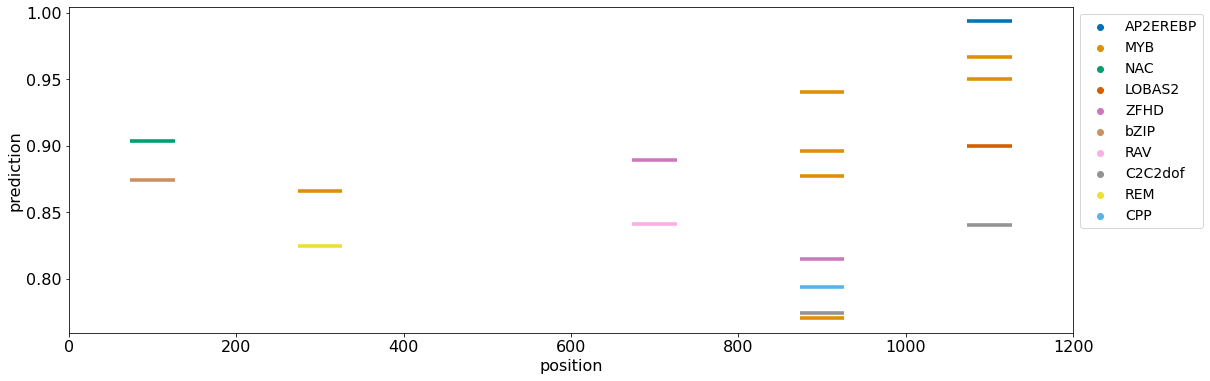

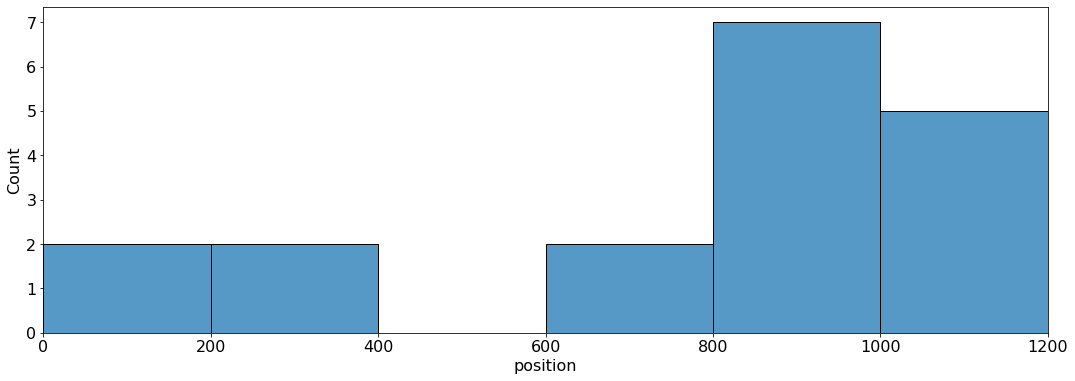

In [30]:
demo = gr.Blocks()

with demo:
    gr.Markdown(
    """
    # Protein-DNA binding prediction
    This app enables the prediction of protein-DNA binding for 217 plant transcription factors on any sequence of interest. 
    
    ## Background
    The model architecture was adapted from the publicly available DeepSTARR architecture (https://doi.org/10.1038/s41588-022-01048-5). Verified binding sites on unmethylated DNA within 200 base pair windows were taken from an ampDAP-seq experiment (https://doi.org/10.1016/j.cell.2016.04.038) to train the models.
    Training was performed on Arabidopsis thaliana chromosomes 1,2,3 and 5 and testing was performed on the held out chromosome 4. For feature extraction the sequences were one-hot encoded and DNA shape features as well as electrostatic potential was extracted using a publicly available query table (https://doi.org/10.1093/nar/gkx1145).
    


    """)
    with gr.Row():
        with gr.Column():
            textbox_input_sequence = gr.Textbox(value=sequence, label="Input sequence")
            button_add_fully_connected = gr.Button("predict binding")
        with gr.Box():
            with gr.Column():
                binding_prediction_plot = gr.Plot(label="Binding prediction")
                with gr.Row():
                    with gr.Column():
                        distribution_plot = gr.Plot(label="Binding prediction distribution")
                    with gr.Column():
                        textbox_best_hits = gr.Textbox(label="High confidence binding predictions")
    
    button_add_fully_connected.click(
        fn=calculate_and_visualize_binding_prediction,
        inputs=[textbox_input_sequence],
        outputs=[binding_prediction_plot, distribution_plot, textbox_best_hits]
    )


demo.launch()